In [1]:
# Example of how to use the ERDDAP server to get data from the Coral Reef Watch dataset
example = "https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km.csv?CRW_DHW[(2020-01-01T12:00:00Z):1:(2020-05-17T12:00:00Z)][(17.175):1:(17.175)][(-87.325):1:(-87.325)],CRW_SST[(2020-01-01T12:00:00Z):1:(2020-05-17T12:00:00Z)][(17.175):1:(17.175)][(-87.325):1:(-87.325)]"


# Let's see what we have here...
root = 'https://pae-paha.pacioos.hawaii.edu/erddap/griddap/'
dataset_id = 'dhw_5km.csv?'
dhw = 'CRW_DHW'
sst = 'CRW_SST'

def date_range(start_date, end_date):
    return f'[({start_date}T12:00:00Z):1:({end_date}T12:00:00Z)]'

def lat_long_range(lat, lon):
    return f'[({lat}):1:({lat})][({lon}):1:({lon})]'

def get_url(start_date, end_date, lat, lon):
    lat, lon = str(lat), str(lon)
    return root + dataset_id + dhw + date_range(start_date, end_date) + lat_long_range(lat, lon) + ',' + sst + date_range(start_date, end_date) + lat_long_range(lat, lon)

# test
test = get_url('2020-01-01', '2020-05-17', '17.175', '-87.325')
print(example == test)
print(example)
print(test)


True
https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km.csv?CRW_DHW[(2020-01-01T12:00:00Z):1:(2020-05-17T12:00:00Z)][(17.175):1:(17.175)][(-87.325):1:(-87.325)],CRW_SST[(2020-01-01T12:00:00Z):1:(2020-05-17T12:00:00Z)][(17.175):1:(17.175)][(-87.325):1:(-87.325)]
https://pae-paha.pacioos.hawaii.edu/erddap/griddap/dhw_5km.csv?CRW_DHW[(2020-01-01T12:00:00Z):1:(2020-05-17T12:00:00Z)][(17.175):1:(17.175)][(-87.325):1:(-87.325)],CRW_SST[(2020-01-01T12:00:00Z):1:(2020-05-17T12:00:00Z)][(17.175):1:(17.175)][(-87.325):1:(-87.325)]


In [1]:
reefs = {
    "great": {
        "lat": -18.175,
        "lon": 147.425
    },
    "florida": {
        "lat": 24.675,
        "lon": -81.225
    },
    "belize": {
        "lat": 17.175,
        "lon": -87.325
    },
    "redsea": {
        "lat": 32.525,
        "lon": 24.825
    },
    "tubbataha": {
        "lat": 8.575,
        "lon": 119.575
    }
}

In [3]:
import requests
import csv
import io
import pandas as pd
import datetime
def request_and_save(reef, start_date='1985-04-01', end_date = None, out_file = None):
    end_date = datetime.now().strftime('%Y-%m-%d') if end_date is None else end_date
    url = get_url(start_date, end_date, reefs[reef]["lat"], reefs[reef]["lon"])
    response = requests.get(url)
    if response.status_code==200:
        data = []
        for i, line in enumerate(csv.reader(io.StringIO(response.text))):
            if i == 0:
                line = ["year", "month", "day", "latitude", "longitude", "dhw", "sst"]
            elif i == 1:
                continue
            else:
                date = datetime.datetime.strptime(line[0], '%Y-%m-%dT%H:%M:%SZ')
                rest = [float(i) for i in line[1:]]
                line = [date.year, date.month, date.day] + rest
            data.append(line)

        df = pd.DataFrame(data[1:], columns=data[0])
        fname = reef if out_file is None else out_file
        fname = fname if fname.endswith('.csv') else fname + '.csv'
        df.to_csv(fname, index=False)
        return df
    return None

In [5]:
for reef in reefs:
    for year in range(1985, 2024+1):
        start_date = f'{year}-04-01' if year == 1985 else f'{year}-01-01'
        end_date = f'{year}-03-31' if year == 2024 else f'{year}-12-31'
        print(reef, year)
        rtn = request_and_save(reef, out_file = f"{reef}_{year}", start_date=start_date, end_date=end_date)
        if rtn is not None:
            #print(rtn.head())
            print("request successful")
        else:
            print("request failed")

great 2024
request successful
florida 2024
request successful
belize 2024
request successful
redsea 2024
request successful
tubbataha 2024
request successful


In [3]:
# concatenate all the files
import pandas as pd
for reef in reefs:
    fname = reef + '_all.csv'
    all_df = None
    for year in range(1985, 2024+1):
        next_df = pd.read_csv(f"{reef}_{year}.csv")
        all_df = next_df if all_df is None else pd.concat([all_df, next_df])
    all_df.to_csv(fname, index=False)

<Axes: xlabel='date'>

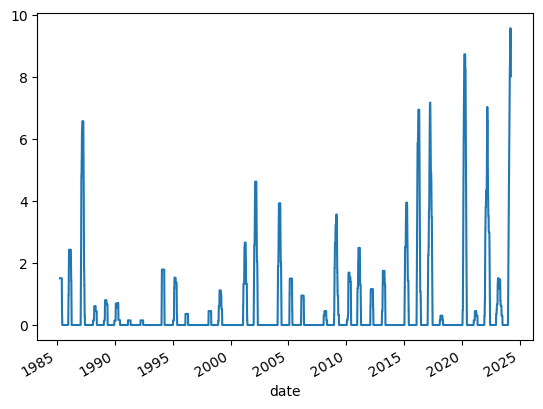

In [4]:
# let's look at a line plot of the great barrier reef
import matplotlib.pyplot as plt
df = pd.read_csv('great_all.csv')
df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
df.set_index('date', inplace=True)
df['dhw'].plot()

<Axes: xlabel='date'>

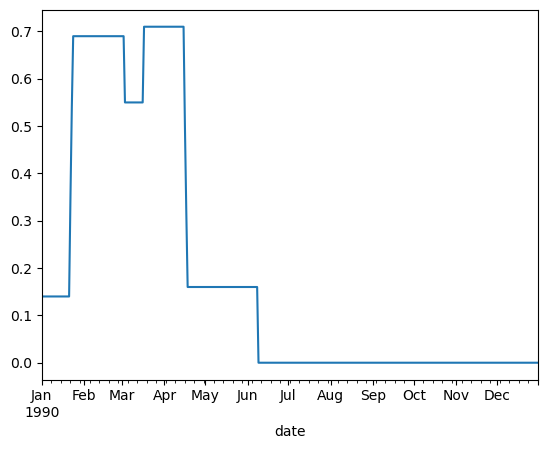

In [11]:
yr = 1990
sub = df.loc[f'{yr}-01-01':f'{yr}-12-31']
sub['dhw'].plot()
